## Breast Cancer Prediction Challenge
#### by Dr. Robert Rankin

Welcome to my little data challenge: predict tumors [0,1] based on messy predictors with missing data (for an Insight Data challenge.

The main trouble with this data is <b>missingness</b>. We can't just delete the rows, otherwise we'd lose a third of the data. So, I explore 3 different ways to handle the missingness:
+ XGBoost (let its internal algo handle the missingness)
+ mean-filling
+ multiple imputation.

### XGBoost
`XGBoost` uses stochastic boosting with decision trees for classification. Missingness is handled internally, such that the trees can handle missingness for making splitting decisions. The handling of missingness is (I believe) informed by the objective function. Therefore, this represents perhaps the best out-of-box solution for having an integrated prediction solution including missinging.

### Mean imputation
Just impute the means of the distribution of the non-missing data, per feature. This reduces the variance and is static, so potentially shouldn't work as well (in terms of an out-of-sample classifcation) as more sophisticated methods (like multiple imputation and XGBoost) where the missing value imputation is learned to some extent.

### Multiple Imputation
In this Challenge, I will try to manually do my own 'multiple imputation' (just for fun). The idea is to:
+ intialize the missing values to some value
+ loop through each predictor/feature
+ bootstrap the data
+ predict the missing values for feature j conditional on all other features (minus j) and the response variable.
+ repeat per feature and per bootstrap (upto 100 times)
+ take the 100 bootstrapped imputations, and calculate and expected value <b> for each missing value </b>

If the multiple imputation works, we'd expect the missing values to converge on some value.

In [25]:
import os
import re
import pandas as pd
import numpy as np
import fancyimpute
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import metrics 
from sklearn.cross_validation import KFold
import shap
 
 # set the working directory
d_file = "../breast-cancer-wisconsin.csv" # no header


In [2]:
# import data
draw = pd.read_csv(d_file,header=None)
# declare the column names
draw.columns = ['id', 'thick','cellsize', 'cellshape', 'marg_adhesion', 'epicellsize','barenucl','chromatin','nucleoli_norm','mitoses','y']

# set which columns are continuous vs. categorical; which is the response/target/y
response = "y"
categorical_col = ["epicellsize"]
category_order = {'epicellsize' : ['small','medium','large']}
predictors = ['thick','cellsize', 'cellshape', 'marg_adhesion', 'epicellsize','barenucl','chromatin','nucleoli_norm','mitoses']


## Data clean up
The data is ugly and messed up! So, I have a little helper function which cleans up the data types, records which values are missing (stored as matrix `missing`)

In [3]:
def PrepData(df, predictors, response, categorical_col = None, category_order=None):
   # convert the response to a binary
   df[response] = (df[response]==max(df[response]))*1
   stor_missing = np.empty(df[predictors].shape,dtype=bool) # keep a dictionary of all the missing values
   # loop through continuous (non-categorical) variables
   for p in [p for p in predictors if p not in categorical_col]:
      # remove string contaminations ('?') and coerce to float
      newp = pd.to_numeric(((df[p].astype('str')).str.replace(r'\D+','')),errors='coerce')
      p_nulls = newp.isnull()
      stor_missing[:,[predictors.index(j) for j in predictors if j==p]] = p_nulls.values.reshape(p_nulls.shape[0],1)
      df[p] = newp
   # loop through categorical variables: clean
   for p in [p for p in predictors if p in categorical_col]:
      newp = np.empty(df.shape[0]);
      newp.fill(np.nan)
      for k in range(0,len(category_order[p])):
         ix_insert_k = np.where(df[p]==category_order[p][k])
         newp[ix_insert_k] = k
      df[p] = newp
      stor_missing[:,[predictors.index(j) for j in predictors if j==p]] = (np.isnan(newp)).reshape(newp.shape[0],1)
   return df,stor_missing

# prep the data for XGBoost
d, missing = PrepData(draw, predictors, response, categorical_col, category_order)
nX = len(predictors)


## Visualize the data
Let's make some histograms to inspect the data

Notice that the data is:
+ highly skewed
+ quasi-continous (actually <b>bounded</b> above and below

The skew and quasi-continuous nature of the data naturally suggest we use <b>decision trees</b> which doesn't bother with data transformations, skew, or boundedness

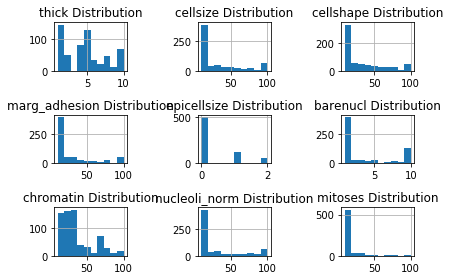

In [4]:
d.describe()
%matplotlib inline
import matplotlib.pyplot as plt
# loop through and plot all the values
def draw_histograms(df, variables, n_rows, n_cols):
   fig=plt.figure()
   for i, var_name in enumerate(variables):
      if draw.dtypes[predictors[i]]=='float64':
         ax=fig.add_subplot(n_rows,n_cols,i+1)
         (df[var_name][~np.isnan(df[var_name]).values]).hist(bins=10,ax=ax)
         ax.set_title(var_name+" Distribution")
   fig.tight_layout()  # Improves appearance a bit.
   plt.show()

draw_histograms(draw, predictors, 3, 3)

## Core Fitting Function
The following will run XGBoost and perform cross-validation, as well as automatically taking the <b>length of the tree-ensemble</b> to be that which minimizes the out-of-sample loss.

Notice we must RECYCLE the cross-validation indices (`Kfold`) so that we can compare each 3 methods consistently.

In [5]:
# fitting function
def modelfit(alg, dtrain, predictors, response,useTrainCV=True, cv_folds=5, early_stopping_rounds=50,kf=None, plot=False):
   if useTrainCV:
      xgb_param = alg.get_xgb_params()
      xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[response].values)
      # predefined cross-validation indicies
      if kf == None:
         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,  metrics='auc', early_stopping_rounds=early_stopping_rounds)
      else:
         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', folds = kf, kearly_stopping_rounds=early_stopping_rounds)
      alg.set_params(n_estimators=cvresult.shape[0])
   #Fit the algorithm on the data
   alg.fit(dtrain[predictors], dtrain[response],eval_metric='auc')
   #Predict training set:
   dtrain_predictions = alg.predict(dtrain[predictors])
   dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
   #Print model report:
   print("Accuracy : %.4f" % metrics.accuracy_score(dtrain[response].values, dtrain_predictions))
   print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[response], dtrain_predprob))
   feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
   if plot:
      import matplotlib.pyplot as plt
      feat_imp.plot(kind='bar', title='Feature Importances')
      plt.ylabel('Feature Importance Score')
      plt.show()
   return alg, cvresult, feat_imp

# set the kfolds manually (for consistency)
n = draw.shape[0]
kf = KFold(n = n, n_folds = 5,shuffle=True, random_state = 1000)


## Model 1: XGBoost (native)
The first model just lets XGBoost handle the missingness internally

Accuracy : 0.9771
AUC Score (Train): 0.998723


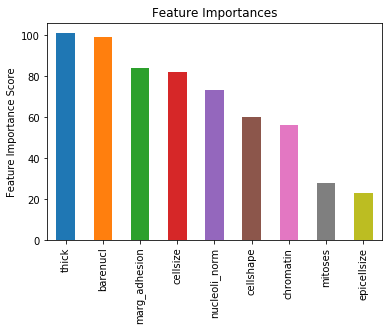

In [7]:
# part one: just let xgboost handle the missing data
# run xgboost with the imputed values
gb_noimpute = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.66,
 colsample_bytree=0.66,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

# custom set the Kfolds for consistency
gb_noimpute_fitted, cvres_noimpute, fimp_noimpute = modelfit(gb_noimpute, d[predictors + [response]], predictors,response, kf, plot=True)


Let's also make some partial dependency plots (at the means of all the other predictors) to visualize the relationship between each predictor/feature and the probability of cancer.

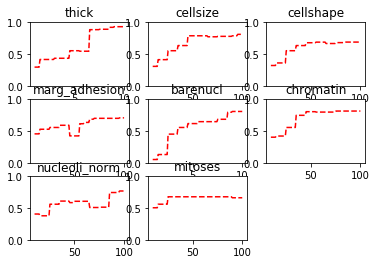

In [9]:
# for partial dependence, we first need to set each covariate to it's mean
mean_data = d[predictors].mean(axis=0)
np_meandata = np.transpose((np.repeat(mean_data.values,100)).reshape(len(predictors),100)) 
# make a data frame of all just mean data
pd_meandata = pd.DataFrame(np_meandata, columns = predictors)
for k in categorical_col:
   pd_meandata[k] = pd_meandata[k].astype(int)

# loop through each predictor, plot its partial dependence
import matplotlib.pyplot as plt
fig = plt.figure()
for j,k in enumerate([p for p in predictors if p not in categorical_col]):
   tmp_plot_data = pd_meandata.copy()
   tmp_plot_data[k] = np.linspace(d[k].min(), d[k].max(),100)
   # get the prediction
   f = gb_noimpute.predict_proba(tmp_plot_data)
   plt.subplot(3, 3, j+1)
   plt.plot(tmp_plot_data[k], f[:,1],"r--")
   plt.title(k)
   plt.ylim([0, 1])
   #plt.ylabel("probibility of breast cancer")
plt.show()


## Model 2: Impute missing values with each features' empirical mean/mode
In this case, we merely fill all missing values with that features mean/mode. Again, we will run cross validation and XGBoost, and inspect the partial plots

Accuracy : 0.9800
AUC Score (Train): 0.998433


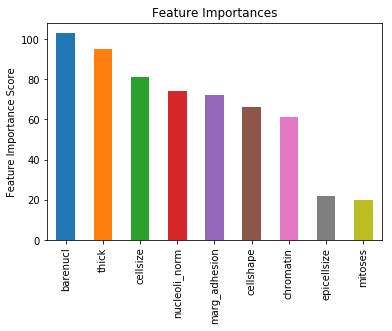

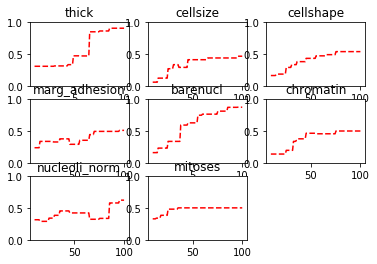

In [10]:
# part two: impute medians (or modes for categorical data)
dm = d.copy()
for i,pr in enumerate(predictors):
   if pr not in categorical_col:
      mu = dm[pr].mean()
      dm[pr] = dm[pr].fillna(mu)
   else:
      mu = dm[pr].mode()
      dm[pr] = dm[pr].fillna(mu[0])

# run xgboost with the imputed values
gb_meanfill = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.66,
 colsample_bytree=0.66,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

gbfitted_meanfill, cvresults__meanfill, feat_imp_meanfill = modelfit(gb_meanfill, dm[predictors + [response]], predictors,response, kf, plot=True)

# loop through each predictor, plot its partial dependence
import matplotlib.pyplot as plt
fig = plt.figure()
for j,k in enumerate([p for p in predictors if p not in categorical_col]):
   tmp_plot_data = pd_meandata.copy()
   tmp_plot_data[k] = np.linspace(d[k].min(), d[k].max(),100)
   # get the prediction
   f = gbfitted_meanfill.predict_proba(tmp_plot_data)
   plt.subplot(3, 3, j+1)
   plt.plot(tmp_plot_data[k], f[:,1],"r--")
   plt.title(k)
   plt.ylim([0, 1])
   #plt.ylabel("probibility of breast cancer")
plt.show()

The results are not much different from XGBoost: both in terms of accuracy, partial plots, or the feature importance

## Model 3: Multiple Imputation
Here, we will repeatly bootstrap the data, and use all the features to predict the values for their respective missing data. There are multple loops:
+ loop through multiple bootstraps
+ loop through each feature (to predict its missing values using all the other features)

Let's start by making some grand functions that handle the dropping+predicting


In [12]:
 # PART 3: MCMC imputation and (De)Weighted Regresion (McImpDeWe)

# initialize with the means
def mcimpdewe_init(d,predictors,categorical_col): 
   dm = d.copy()
   for i,pr in enumerate(predictors):
      if pr not in categorical_col:
         mu = dm[pr].mean()
         dm[pr] = dm[pr].fillna(mu)
      else:
         mu = dm[pr].mode()
         dm[pr] = dm[pr].fillna(mu[0])
   return dm

# special fitting for the multiple imputation
def modelfit_impdewe(alg, dtrain, predictors, response, preddata,useTrainCV=True, cv_folds=5, early_stopping_rounds=50,kf=None):
   if useTrainCV:
      xgb_param = alg.get_xgb_params()
      xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[response].values)
      # predefined cross-validation indicies
      cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, early_stopping_rounds=early_stopping_rounds)
      alg.set_params(n_estimators=cvresult.shape[0])
   #Fit the algorithm on the data
   alg.fit(dtrain[predictors], dtrain[response])
   newpred = alg.predict(preddata)
   return newpred, alg, cvresult
 
# do one round of imputation
def mcimpdewe_impute_p(data, # current data
                       predictors,
                       response,
                       target_p,
                       categorical_col, 
                       missing, # boolean matrix of (same shape as dat) with True=NaN, False is not
                       learning_rate =0.05,
                       n_estimators=2000
                       ):
   # current data: concatenate the response and predictors
   curdat = (data[predictors+[response]]).copy()
   predictors_minus_target = [p for p in predictors if p not in [target_p]]+[response]
   # get indices for imputation
   target_k = [i for i in range(0,len(predictors)) if predictors[i] == target_p]
   # bootstrap the fitting data
   bootdata = (curdat.iloc[np.random.choice(curdat.shape[0],curdat.shape[0],replace=True),:]).copy()
   # prediction: where there are missing values
   preddata = (pd.DataFrame((curdat[predictors_minus_target].values[np.where(missing[:,target_k]),:])[0])).copy()
   preddata.columns = predictors_minus_target
   # get the loss function
   if target_p in categorical_col:
      curdat[target_p] = curdat[target_p].astype(int)
      num_class = len(curdat[target_p].unique())
      if num_class >2:
         objective = "multi:softmax"
      else:
         objective = "binary:logistic"
      gbmod = XGBClassifier(learning_rate =learning_rate,n_estimators=n_estimators,max_depth=3,min_child_weight=1,gamma=0,subsample=0.5,colsample_bytree=0.5,objective=objective,nthread=4,scale_pos_weight=1,num_class=num_class)
   else:
      objective = "reg:linear"
      num_class=None
      gbmod = XGBClassifier(learning_rate =learning_rate,n_estimators=n_estimators,max_depth=3,min_child_weight=1,gamma=0,subsample=0.5,colsample_bytree=0.5,objective=objective,nthread=4,scale_pos_weight=1)
   # impute data
   tmppred, tmp_modfit, tmp_cvres = modelfit_impdewe(gbmod, bootdata, predictors_minus_target, target_p, preddata, cv_folds=3)
   new_values = curdat[target_p]
   if objective != "reg:linear":
      tmppred = tmppred.astype(int)
   new_values[np.where(missing[:,target_k])[0]] = tmppred
   return_data = data.copy()
   return_data[target_p] = new_values
   if objective != "reg:linear":
      return_data[target_p] = return_data[target_p].astype(int)
   del gbmod
   return return_data, tmppred


First we initialize the chain of imputated values with the empirical means

In [13]:
dm = mcimpdewe_init(d,predictors, categorical_col) # initialize (stochastic) chain of imputed values

Next, we do 30 iterations, each time bootstrapping the data. Per bootstrap, we'll then loop through each feature, treat it as the "response variable" for the other features to learn, and then predict the values of its missing values.

In [14]:
nImputeIterations = 30
stochastic_preds = {} # empty dictionary, to store stochastic values
for i,k in enumerate(predictors):
   stochastic_preds[k] = np.zeros((sum(missing[:,i]),nImputeIterations)) 

dm_new, tmpred = mcimpdewe_impute_p(dm, predictors, response, predictors[0], categorical_col, missing, learning_rate =0.1,n_estimators=100)
for i in range(0,nImputeIterations):
   for k,target_p in enumerate(predictors):
      # predicting new values; bootstrapping the data
      dm_new, tmpred = mcimpdewe_impute_p(dm_new, predictors, response, target_p, categorical_col, missing, learning_rate =0.1,n_estimators=100)
      stochastic_preds[target_p][:,i] = tmpred


/home/rob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finally, for each missing value for each feature, get its expected value (the mean over all bootstrap/imputation). If I had more time, I would try to go Bayesian and impute the <b>entire distribution</b> of all values. But, in truth, they all seem to converge on values. Therefore, we just impute this final expected value (per missing value per feature), and then run a final `XGBoost` model for the final predictions (i.e., assuming there is no variance to the uncertainty of the predicted points).

/home/rob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Accuracy : 0.9785
AUC Score (Train): 0.998206


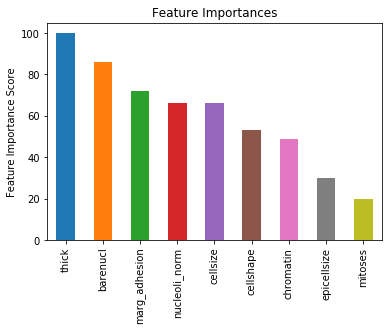

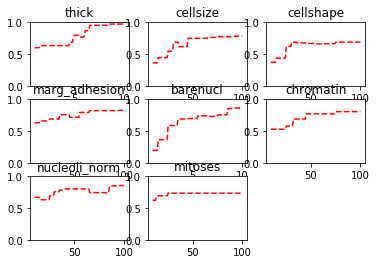

In [17]:
# get the mean values of the stochstic imputation
for i,k in enumerate(predictors):
   imputed_values = stochastic_preds[k].mean(axis = 1)
   dm_new[k][np.where(missing[:,i])[0]] = imputed_values
   if k in categorical_col:
      dm_new[k] = dm_new[k].astype(int)

 
# now that the final values have stabilized: perform a final prediction
gbimpute = XGBClassifier(learning_rate =0.05,n_estimators=1000,max_depth=3,min_child_weight=1,gamma=0,subsample=0.66,colsample_bytree=0.66,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
gbfitted_impute, cvresults_impute, feat_imp_impute = modelfit(gbimpute, dm_new[predictors + [response]], predictors,response, kf, plot=True)

fig = plt.figure()
for j,k in enumerate([p for p in predictors if p not in categorical_col]):
   tmp_plot_data = pd_meandata.copy()
   tmp_plot_data[k] = np.linspace(d[k].min(), d[k].max(),100)
   # get the prediction
   f = gbfitted_impute.predict_proba(tmp_plot_data)
   plt.subplot(3, 3, j+1)
   plt.plot(tmp_plot_data[k], f[:,1],"r--")
   plt.title(k)
   plt.ylim([0, 1])
   #plt.ylabel("probibility of breast cancer")
plt.show()


## Final Results

The models are very similar, in terms of predicted accuracy, partial plots, and feature importance.
Generally, I would favour the multiple imputation or XGBoost native handling of missing values, rather than mean-imputation.

Let's look at the out-of-sample AUC scores. 

In [24]:
print("CV-AUC for XGBoost (native) is %0.3f" % cvres_noimpute["test-auc-mean"].min());
print("CV-AUC for Mean-imputation is is %0.3f" % cvresults__meanfill["test-auc-mean"].min())
print("CV-AUC for Mean-imputation is is %0.3f" % cvresults_impute["test-auc-mean"].min())

CV-AUC for XGBoost (native) is 0.968
CV-AUC for Mean-imputation is is 0.973
CV-AUC for Mean-imputation is is 0.974


### Multiple Imputation is best!
Hardly to rave about, that tiny difference by which multiple-imputation works. Nonetheless, that could save lives!